In [2]:
import pandas as pd
import numpy as np
import requests
import re
from Bio import SeqIO
import subprocess
from random import sample
from scipy.stats import entropy

def ko2genes(ko):
    url = 'http://rest.kegg.jp/link/genes/' + ko
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['ko','gene'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

def download_seqs(geneList,fileName,batchSize):    
    geneList_chunks = [geneList[i * batchSize:(i + 1) * batchSize] for i in range((len(geneList) + batchSize - 1) // batchSize )]
    with open(fileName,'w') as fastafile:
        for sglist in geneList_chunks:
            url =  'http://rest.kegg.jp/get/' + "+".join(sglist) + '/aaseq'
            fseqs = requests.get(url).text
            fastafile.write(fseqs)

            
def msaSeq2df(seq,indexStart):
    idx = []
    resid = []
    j = indexStart;
    for i in seq:
        resid.append(i)
        if i == '-':
            idx.append(np.nan)
        else:
            idx.append(j)
            j = j+1
    
    return pd.DataFrame({'residue': resid, 'index': idx})

def ecogenes():
    url = 'http://rest.kegg.jp/link/ko/eco'
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['gene','ko'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

get_resid = lambda x: [x for x in re.findall(r'\D',x) if len(x)>0][0]
get_resid_idx = lambda x: [int(x) for x in re.findall(r'\d*',x) if len(x)>0][0]


# load all structural annotations
structure = pd.read_csv('../assets/structure/residueTable.66genes.csv',index_col=0)

structure['gene name (KO)'] = structure['gene name'] + ' (' + structure['KO'] + ')'

In [3]:
structure

,gene name,uniprot,KO,Redundancy,Unique oxidoreductase reactions,iJO1344-reactions,Structure,Coenzyme Bound Structure,Homolog-Species,Homolog-KEGG,Homolog-Uniprot,Residues,Coenzyme,% Identity,Notes,gene name (KO)
gene id,,,,,,,,,,,,,,,,
b0002,thrA,P00561,K12524,Not unique,NaN,NaN,6MX1,6DZS,Mycolicibacterium hassiacum DSM 44199,has:MHAS_02717,K5BJC9,R50;R51;R56,NADP,NaN,hom;,thrA (K12524)
b0031,dapB,P04036,K00215,NaN,DHDPRy,DHDPRy,1ARZ,1ARZ,Esherichia coli K12,eco:b0031,P04036,E38,NAD,100,dapB,dapB (K00215)
b0116,lpdA,P0A9P0,K00382,NaN,AKGDH;GLYCL;PDH,AKGDH;GLYCL;PDH,4JDR,1LVL,Psuedomonas putida,ppu:PP_4404,P09063,E202,NAD,NaN,lpdV (structural is from different strain),lpdA (K00382)
b0173,dxr,P45568,K00099,NaN,DXPRIi,DXPRIi,3ANL,3ANL,Esherichia coli K12,eco:b0173,P45568,T10;N38;K37,NADPH,100,Binding through peptide backbone,dxr (K00099)
b0356,frmA,P25437,K00121,NaN,ALCD19;FALDH2,ALCD19;FALDH2,None,3UKO,Arabidopsis thaliana,ath:AT5G43940,Q96533,D226,NAD,59.1,NADH bound,frmA (K00121)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b3575,yiaK,P37672,K08092,NaN,DOGULNR,NaN,"1NXU,1S20",1S20,Esherichia coli K12,eco:b3575,P37672,E306,NAD,NaN,NaN,yiaK (K08092)
b3924,fpr,P28861,K00528,NaN,FLDR2,NaN,"1FDR,2XNJ",2XNJ,Esherichia coli K12,eco:b3924,P28861,S173;R174;R184,NADP,NaN,NaN,fpr (K00528)
b3941,metF,P0AEZ1,K00297,NaN,MTHFR2,NaN,"3FST,3FSU,1ZP3,1ZP4,1ZPT,2FMN,1ZRQ,2FMO,1B5T,6PEY",1ZP4,Esherichia coli K12,eco:b3941,P0AEZ1,T59,NADH,NaN,L277 could exclused phosphate on 2' hydroxyl f...,metF (K00297)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


def label_point(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], point['val'])
        
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"]})

In [5]:

ko_list =  [];
residue_list = []
residue_ref_idx = []
residue_msa_idx = []
count_occured = []
count_not_occured = []
frac_occured = []

dfs = []
residues = np.array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'])
for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf[seqdf['index'].isin(r['index'].tolist())]
            for midx,row2 in sdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                
                #c = [chars.count(x) for x in list(set(chars))]
                c= [chars.count(x) for x in residues]
                c = [x + 0.5 for x in c]
                pk = np.array(c)/sum(c)
                site_entropy = entropy(pk)
                
                z = pd.DataFrame({'idx':chars}).reset_index().groupby('idx').count()
                z2 = z.reset_index()
                z2.columns = ['residue','numSeqs']
                z2['ref_residue'] = row2.residue
                z2['ref_residue_idx'] = row2['index']
                z2['entropy'] = site_entropy
                z2['KO'] = ko
                dfs.append(z2)
                #frac = z.loc[row2.residue]['index'] / z['index'].sum()
                ##ko_list.append(ko)
                #residue_list.append(row2.residue)
                #residue_ref_idx.append(row2['index'])
                #residue_msa_idx.append(midx)
                #count_occured.append(z.loc[row2.residue]['index'])
                #count_not_occured.append(z['index'].sum() - z.loc[row2.residue]['index'])
                #frac_occured.append(frac)

dfs = pd.concat(dfs,axis=0)                

#r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]
#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [6]:
dfs

,residue,numSeqs,ref_residue,ref_residue_idx,entropy,KO
0,-,258,E,38.0,1.888932,K00215
1,A,27,E,38.0,1.888932,K00215
2,C,10,E,38.0,1.888932,K00215
3,D,280,E,38.0,1.888932,K00215
4,E,239,E,38.0,1.888932,K00215
...,...,...,...,...,...,...
11,R,5,N,58.0,1.692463,K00040
12,S,300,N,58.0,1.692463,K00040
13,T,83,N,58.0,1.692463,K00040
14,V,24,N,58.0,1.692463,K00040


In [28]:
#residues = np.array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'])

In [29]:
residues

array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q',
       'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'], dtype='<U1')

In [7]:
df_new = []
for idx,dff in dfs.groupby('KO'):
    dff['conservation'] = dff['numSeqs'] /dff['numSeqs'].sum()
    residues = dff['ref_residue'].unique().tolist()
    if len(residues) == 1:
        if residues[0] in ['E','D']:
            dff['D/E'] = True
        else:
            dff['D/E'] = False
    else:
        dff['D/E'] = False
        
    coenzyme = structure[structure.KO == idx]['Coenzyme'].tolist()[0]
    if coenzyme in ['NAD','NADH']:
        dff['coenzyme'] = 'NAD'
    elif coenzyme in ['NADP','NADPH']:
        dff['coenzyme'] = 'NADP'
    else:
        dff['coenzyme'] = 'None'
    df_new.append(dff)
df_new = pd.concat(df_new,axis=0)

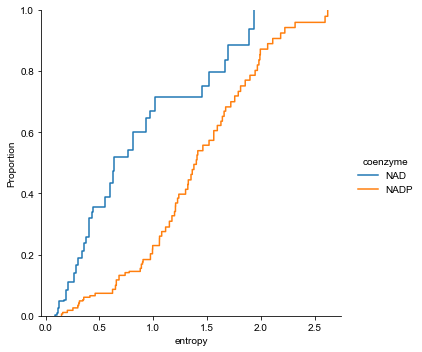

In [8]:
sns.displot(data=df_new,x='entropy',hue='coenzyme',kind='ecdf')

In [9]:
df_new

,residue,numSeqs,ref_residue,ref_residue_idx,entropy,KO,conservation,D/E,coenzyme
0,-,14,D,29.0,0.353942,K00012,0.0140,True,NAD
1,D,948,D,29.0,0.353942,K00012,0.9480,True,NAD
2,E,24,D,29.0,0.353942,K00012,0.0240,True,NAD
3,H,3,D,29.0,0.353942,K00012,0.0030,True,NAD
4,N,2,D,29.0,0.353942,K00012,0.0020,True,NAD
...,...,...,...,...,...,...,...,...,...
4,T,30,S,303.0,0.412181,K19265,0.0150,False,NADP
0,-,4,Q,307.0,0.300957,K19265,0.0020,False,NADP
1,E,1,Q,307.0,0.300957,K19265,0.0005,False,NADP
2,H,47,Q,307.0,0.300957,K19265,0.0235,False,NADP


In [10]:
de_only = df_new[df_new['D/E'] & (df_new['coenzyme'] == 'NAD')]
de_only.set_index('residue')[['KO','conservation']]

,KO,conservation
residue,,
-,K00012,0.014
D,K00012,0.948
E,K00012,0.024
H,K00012,0.003
N,K00012,0.002
...,...,...
E,K13953,0.012
G,K13953,0.005
S,K13953,0.029


In [11]:
#de_only.set_index('residue')[['KO','conservation']].T.plot(y='conservation',kind='bar', stacked=True)

In [12]:
de_only = de_only.pivot_table(index='KO',columns = ['residue'],values='conservation').fillna(0)

In [13]:
import scipy.cluster.hierarchy as sch


In [14]:
de_proportion = pd.DataFrame(de_only['D'] + de_only['E'],columns=['D/E'])

In [15]:
de_freq_gemes = structure.reset_index()[['KO','gene name']].set_index('KO').join(de_proportion).dropna()

In [16]:
de_freq_gemes.sort_values('D/E',ascending=False)

,gene name,D/E
KO,,
K03473,pdxB,1.000000
K00073,allD,1.000000
K06447,astD,0.997000
K01825,fadB,0.996898
K00121,frmA,0.995000
K00060,tdh,0.993000
K00013,hisD,0.987000
K00048,fucO,0.980851
K00024,mdh,0.973000


In [17]:
de_freq_gemes['D/E'] = de_freq_gemes['D/E'] * 100

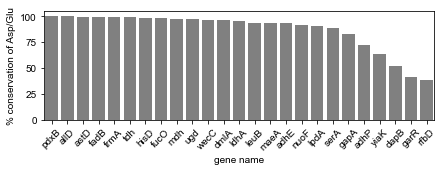

In [226]:
plt.figure(figsize=(7,2))
sns.barplot(x='gene name',y='D/E',data=de_freq_gemes.sort_values('D/E',ascending=False),color='grey')
plt.xticks(rotation=45)
#plt.hlines(1,-0.5,len(de_freq_gemes),colors='k')
#plt.ylim(0,1.1)
plt.ylabel('% conservation of Asp/Glu')
plt.savefig('percentageOfNADBindingGenesConserved.Fat.svg')

/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

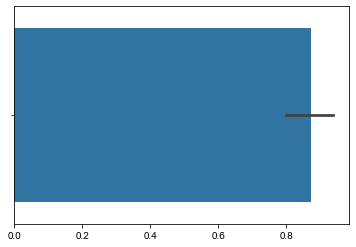

In [128]:
sns.barplot(de_only['D'] + de_only['E'])

<AxesSubplot:xlabel='KO'>

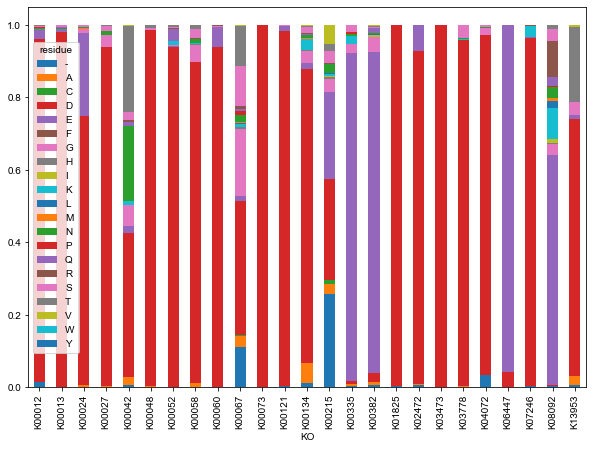

In [69]:
de_only.plot.bar(stacked=True, figsize=(10,7))


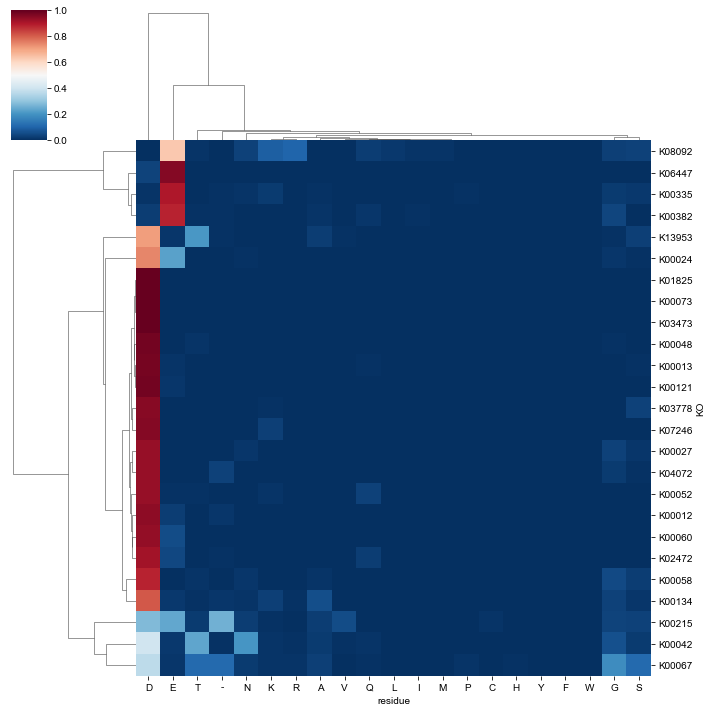

In [60]:
sns.clustermap(de_only,yticklabels=True,cmap='RdBu_r')

In [18]:
de_only

residue,-,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
KO,,,,,,,,,,,,,,,,,,,,,
K00012,0.014000,0.000000,0.000,0.948000,0.024000,0.000,0.000000,0.003000,0.000000,0.000000,...,0.000000,0.002000,0.003000,0.001000,0.000,0.003000,0.002000,0.000,0.000,0.000
K00013,0.001000,0.000000,0.000,0.979000,0.008000,0.000,0.001000,0.000000,0.000000,0.000000,...,0.000000,0.001000,0.000000,0.004000,0.000,0.004000,0.000000,0.000,0.000,0.001
K00024,0.002000,0.003000,0.000,0.744000,0.229000,0.000,0.012000,0.000000,0.000000,0.000000,...,0.001000,0.004000,0.000000,0.000000,0.000,0.005000,0.000000,0.000,0.000,0.000
K00027,0.001000,0.002000,0.000,0.935000,0.001000,0.000,0.032000,0.000000,0.000000,0.000000,...,0.000000,0.012000,0.000000,0.000000,0.000,0.015000,0.001000,0.001,0.000,0.000
K00042,0.006000,0.022000,0.000,0.399000,0.017000,0.000,0.059000,0.000000,0.000000,0.011000,...,0.000000,0.207000,0.000000,0.011000,0.006,0.022000,0.236000,0.004,0.000,0.000
K00048,0.002128,0.002128,0.000,0.980851,0.000000,0.000,0.006383,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.008511,0.000,0.000,0.000
K00052,0.000000,0.002000,0.000,0.937000,0.004000,0.000,0.001000,0.000000,0.000000,0.011000,...,0.000000,0.001000,0.000000,0.033000,0.002,0.002000,0.006000,0.000,0.001,0.000
K00058,0.002000,0.011000,0.000,0.884000,0.001000,0.000,0.047000,0.001000,0.000000,0.003000,...,0.000000,0.013000,0.000000,0.000000,0.002,0.024000,0.011000,0.001,0.000,0.000
K00060,0.000000,0.001000,0.000,0.939000,0.054000,0.000,0.003000,0.001000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001,0.000000,0.000000,0.000,0.000,0.001


In [22]:
ko_list = de_only.index.get_level_values(0).tolist()

In [23]:
de_only_fig = structure[structure.KO.isin(ko_list)][['KO','gene name (KO)']].set_index('KO').join(de_only).set_index('gene name (KO)')

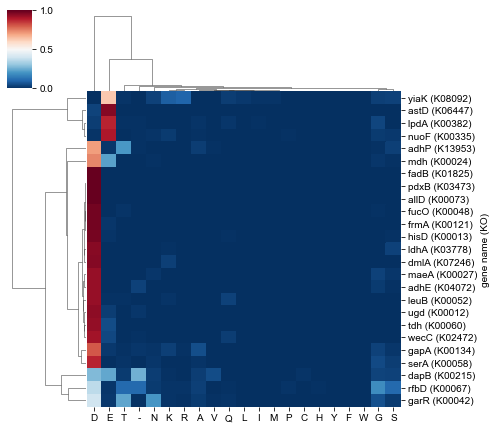

In [24]:
sns.clustermap(de_only_fig,yticklabels=True,xticklabels=True,cmap='RdBu_r',figsize=(7,6))

In [25]:
de_conservation = pd.DataFrame(de_only_fig[['D','E']].sum(axis=1).sort_values(),columns = ['conservation (D/E)'])

In [26]:
df= pd.read_hdf('../scc/relativeGrowthRates.StoichAndThermo.MR4.hdf','df')

In [27]:
mgr = pd.DataFrame(df.min(),columns = ['min growth rate'])

In [28]:
structure_mgr = structure.join(mgr)

In [29]:
l = structure_mgr.reset_index().set_index('gene name (KO)').join(de_conservation)[['min growth rate','conservation (D/E)']].dropna()

In [63]:
l

,min growth rate,conservation (D/E),lethal
gene name (KO),,,
dapB (K00215),0.999998,0.519000,False
lpdA (K00382),1.000000,0.910000,False
frmA (K00121),0.734684,0.995000,False
maeA (K00027),0.999998,0.936000,False
astD (K06447),0.999998,0.997000,False
gapA (K00134),0.000401,0.827000,True
hisD (K00013),0.999998,0.987000,False
ugd (K00012),0.999998,0.972000,False
rfbD (K00067),0.999998,0.382000,False


In [57]:
keep = (l['min growth rate'] < 0.8) | (l['conservation (D/E)'] < 0.94)

In [58]:
x = l[keep]['conservation (D/E)'].values
y = l[keep]['min growth rate'].values
vals = l[keep].index.tolist()
vals = [x.split(' ')[0] for x in vals]

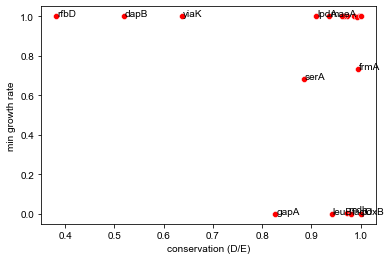

In [60]:
ax =sns.scatterplot(x='conservation (D/E)',y='min growth rate',data=l,color='red')
label_point(x,y,vals,ax)
plt.savefig('minGrowthRate.vs.ConservationDE.labeled.svg')

In [34]:
l['lethal'] = l['min growth rate'] < 0.01

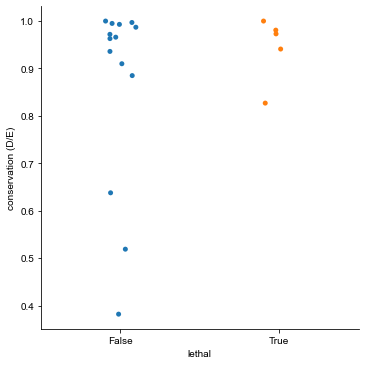

In [35]:
sns.catplot(x='lethal',y='conservation (D/E)',data=l)

In [126]:
from scipy.stats import ranksums

In [131]:
x = l[l['lethal']]['conservation (D/E)'].values
y = l[~l['lethal']]['conservation (D/E)'].values
ranksums(x,y)

RanksumsResult(statistic=0.5092010548749033, pvalue=0.6106113037624283)

In [132]:
y

array([0.519     , 0.91      , 0.995     , 0.936     , 0.997     ,
       0.987     , 0.972     , 0.382     , 0.885     , 0.993     ,
       0.966     , 1.        , 0.963     , 0.63783784])

In [137]:
dff = df_new.groupby(['ref_residue_idx','KO','coenzyme']).mean().reset_index()

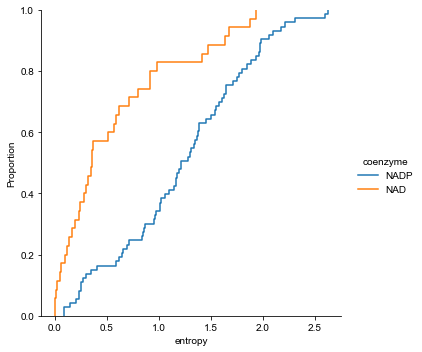

In [139]:
sns.displot(dff,x='entropy',hue='coenzyme',kind='ecdf')

In [96]:
se = {'KO':[],'idx':[],'entropy':[],'coenzyme_residue':[],'percent_gap': [],'coenzyme': []}
residues = np.array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'])


for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            seqdf['coenzymes_residue' ]= seqdf['index'].isin(r['index'].tolist())
            for midx,row2 in seqdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                c = [chars.count(x) for x in residues]
                c = [x + 0.5 for x in c]
                pk = np.array(c)/sum(c)
                site_entropy = entropy(pk)
                se['KO'].append(ko); se['idx'].append(midx); se['entropy'].append(site_entropy); 
                se['coenzyme_residue'].append(row2.coenzymes_residue)
                se['percent_gap'].append(c[0] / sum(c))
                se['coenzyme'].append(row.Coenzyme)
se = pd.DataFrame(se)

In [204]:
se_g = se[se['percent_gap'] < 0.5]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57]),
 [Text(0, 0, 'K00215'),
  Text(1, 0, 'K00382'),
  Text(2, 0, 'K00099'),
  Text(3, 0, 'K00121'),
  Text(4, 0, 'K00286'),
  Text(5, 0, 'K00077'),
  Text(6, 0, 'K01491'),
  Text(7, 0, 'K00384'),
  Text(8, 0, 'K12972'),
  Text(9, 0, 'K00059'),
  Text(10, 0, 'K02492'),
  Text(11, 0, 'K03778'),
  Text(12, 0, 'K13953'),
  Text(13, 0, 'K00027'),
  Text(14, 0, 'K16066'),
  Text(15, 0, 'K06447'),
  Text(16, 0, 'K00262'),
  Text(17, 0, 'K00134'),
  Text(18, 0, 'K00013'),
  Text(19, 0, 'K00012'),
  Text(20, 0, 'K00033'),
  Text(21, 0, 'K00067'),
  Text(22, 0, 'K02377'),
  Text(23, 0, 'K03473'),
  Text(24, 0, 'K00135'),
  Text(25, 0, 'K00058'),
  Text(26, 0, 'K00024'),
  Text(27, 0, 'K00014'),
  Text(28, 0, 'K00133'),
  Text(29, 0, 'K003

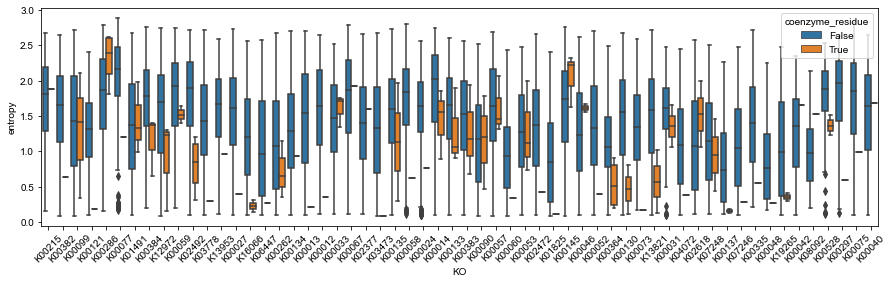

In [205]:
plt.figure(figsize=(15,4))
sns.boxplot(x='KO',y='entropy',hue='coenzyme_residue',data=se_g)
plt.xticks(rotation=45)

In [209]:
#se.apply(lambda x: (x.coenzyme_residue == True) & (x == 'NAD'),axis=1)
se_nad = se[se.coenzyme.isin(['NAD','NADH'])]
se_nadp = se[se.coenzyme.isin(['NADP','NADPH'])]

In [210]:
se.coenzyme.unique()

array(['NAD', 'NADPH', 'NADP', 'NADH'], dtype=object)

In [211]:
seqdf[seqdf.coenzymes_residue]

,residue,index,coenzymes_residue
255,N,58.0,True


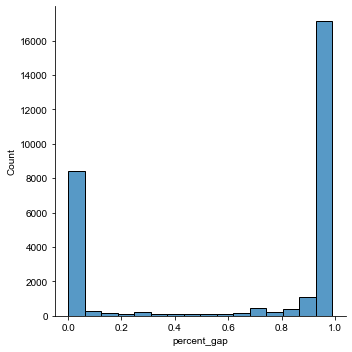

In [212]:
sns.displot(x='percent_gap',data=se_nadp)

In [213]:
se_nad = se_nad[se_nad['percent_gap'] < 0.5]
se_nadp = se_nadp[se_nadp['percent_gap'] < 0.5]

<Figure size 216x216 with 0 Axes>

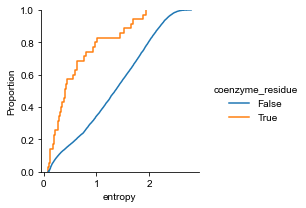

In [214]:
plt.figure(figsize=(3,3))
sns.displot(se_nad,x='entropy',hue='coenzyme_residue',kind='ecdf',height=3)
plt.savefig('ecdf.NADCEnzymes.ResidueSiteEntropyVsOther.svg')

<Figure size 216x216 with 0 Axes>

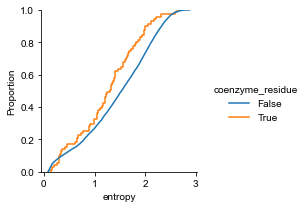

In [215]:
plt.figure(figsize=(3,3))
sns.displot(se_nadp,x='entropy',hue='coenzyme_residue',kind='ecdf',height=3)
plt.savefig('ecdf.NADPCEnzymes.ResidueSiteEntropyVsOther.svg')

In [117]:
from scipy.stats import mannwhitneyu

In [216]:
mannwhitneyu(se_nadp[se_nadp['coenzyme_residue']].entropy.values,se_nadp[~se_nadp['coenzyme_residue']].entropy.values)

MannwhitneyuResult(statistic=275311.0, pvalue=0.004891824613723885)

In [217]:
mannwhitneyu(se_nad[se_nad['coenzyme_residue']].entropy.values,se_nad[~se_nad['coenzyme_residue']].entropy.values)

MannwhitneyuResult(statistic=107149.5, pvalue=1.1445333583085655e-08)

In [223]:
sum(se_nadp.coenzyme_residue)

71

In [224]:
10**(-2)

0.01